## Loading necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

/home/luke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


True

## Loading and preprocessing images

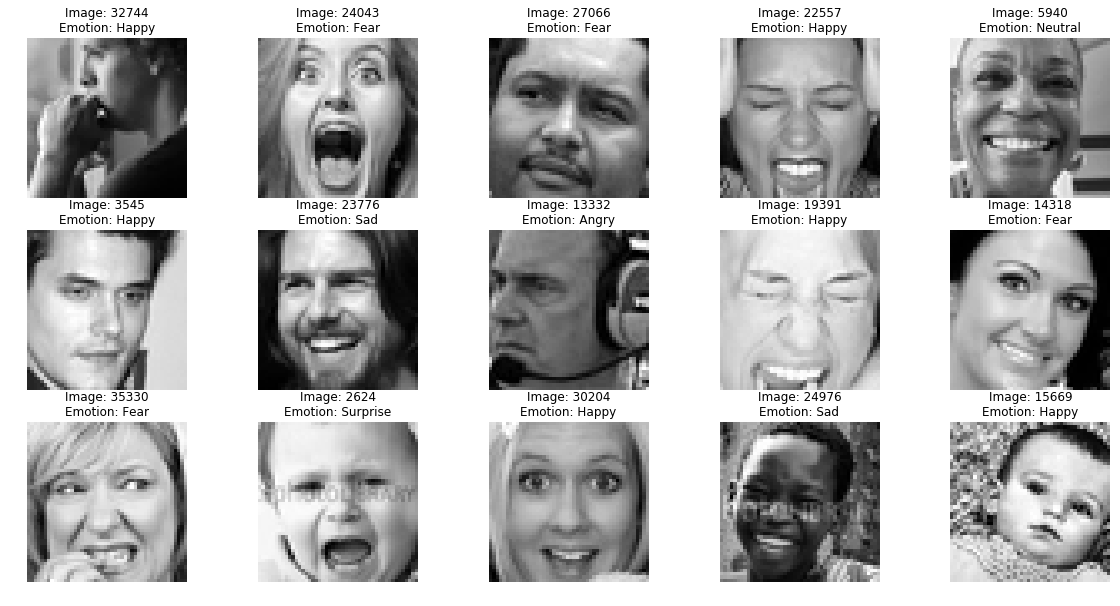

In [47]:
data = pd.read_csv("fer2013.csv")

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

test_idx_start = 32298
images_test = images[test_idx_start:]




# Function for displaying 15 random images
def show(imgs, emotion_nms = None, random = True, indices = None):
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 16)
    else:
        indices = np.random.randint(indices.min(), indices.max(), size = 16)
    plt.figure(figsize=(20, 10)) 
    for index, number in enumerate(indices):
        if isinstance(emotion_nms, type(None)):
            plt.title('Image: ' + str(indices[index-1]))
        else:
            plt.title('Image: ' + str(indices[index-1]) + '\n' + 'Emotion: ' + emotion_nms[number])
        show_image = imgs[number].reshape(48,48)
        try:
            plt.subplot(3,5, index + 1)
        except ValueError:
            continue
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
        
show(images, emotion_nms = data['emotion_name'])



# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [3]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

## Building CNN

In [4]:
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# #4th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
#fully connected neural networks
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 64)        36928     
__________

## Training CNN using Data Augmentation

In [ ]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


# Saving model each time it achieves lower loss on the validation set
filepath='Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    nb_epoch=300,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=[checkpointer,tensorboard]
                             )


## Loading best model and exploring the results

In [6]:
model2 = load_model('Best_model_6759OffTest.hdf5')

In [7]:
scores = model2.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

3589/3589 [==============================] - 39s 11ms/step
Loss: 0.9219519597436432
Accuracy: 0.6759543094039794


In [8]:
# pd.DataFrame(history.history).to_csv("history_val1.csv")
history = pd.read_csv('history.csv', usecols = ['acc','loss','val_acc','val_loss'])

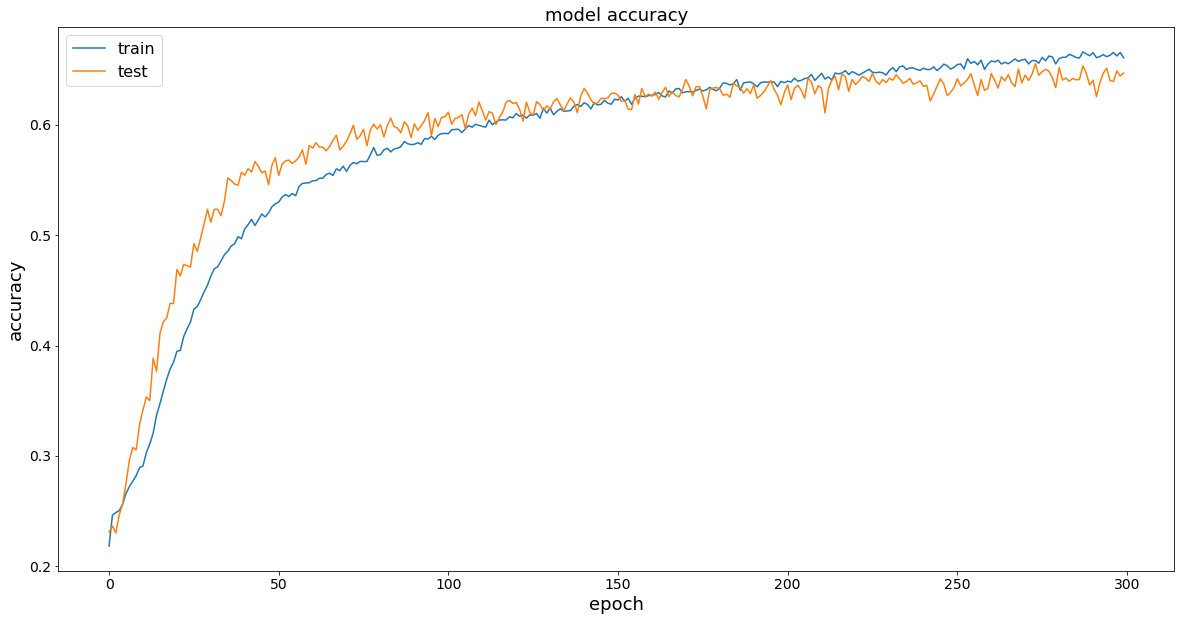

In [9]:
plt.figure(figsize=(20, 10)) 
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy', fontsize = 18)
plt.ylabel('accuracy', fontsize = 18)
plt.xlabel('epoch', fontsize = 18)
plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

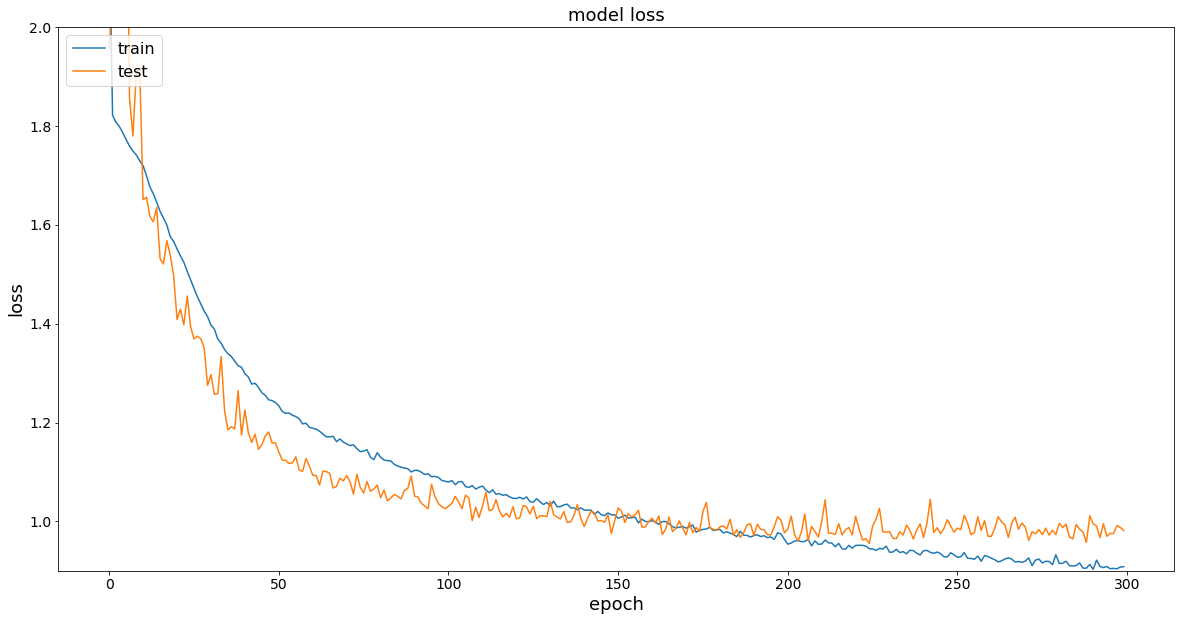

In [10]:
plt.figure(figsize=(20, 10)) 
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss', fontsize = 18)
plt.ylabel('loss', fontsize = 18)
plt.xlabel('epoch', fontsize = 18)
plt.ylim(0.9,2)
plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [50]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results



def visualize_predictions(images_test, label_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show(images_test, emotion_nms = label_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show(images_test, emotion_nms = label_names, random = False, indices = incorrect)
    



In [54]:
correct, results_df = predict_classes(model2, X_test, y_test, emotions_names, batch_size = 1024)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)
results_df[['Original_label', 'Predicted_label', 'True_emotion', 'Predicted_emotion', 'Is_correct']].head(5)

,Original_label,Predicted_label,True_emotion,Predicted_emotion,Is_correct
0,0,0,Angry,Angry,True
1,5,4,Surprise,Sad,False
2,6,4,Neutral,Sad,False
3,4,4,Sad,Sad,True
4,2,0,Fear,Angry,False


In [69]:
results_df.tail()

,Is_correct,Predicted_emotion,Predicted_label,Original_label,True_emotion
3584,True,Neutral,6,6,Neutral
3585,True,Happy,3,3,Happy
3586,False,Disgust,1,0,Angry
3587,True,Happy,3,3,Happy
3588,True,Fear,2,2,Fear


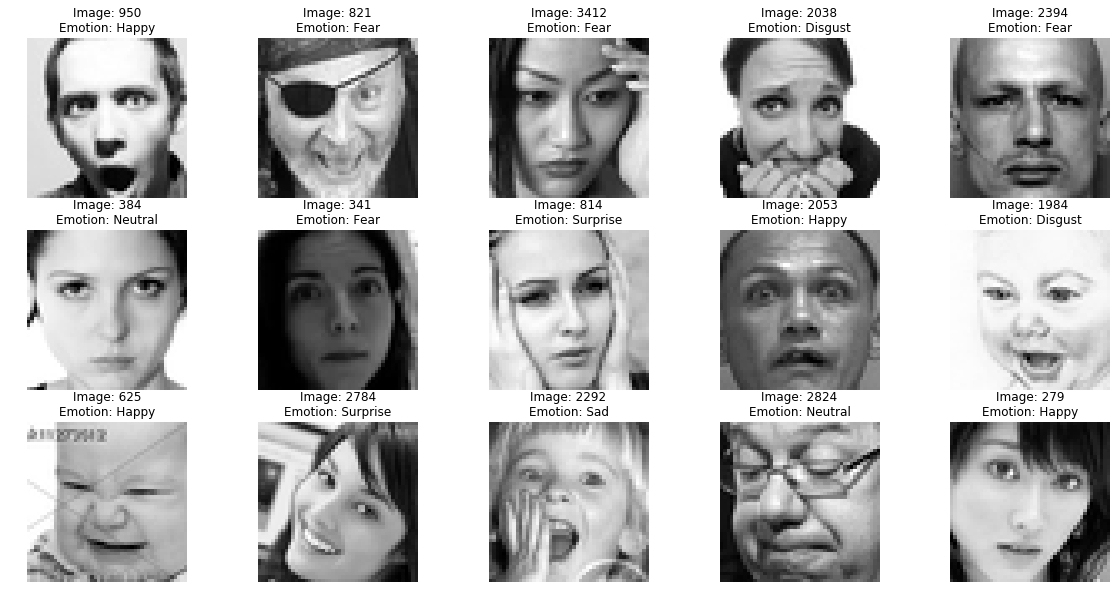

In [59]:
visualize_predictions(images_test, results_df['True_emotion'], correct, valid = False)


In [57]:
results_df[37:40]

,Is_correct,Predicted_emotion,Predicted_label,Original_label,True_emotion
37,False,Sad,4,0,Angry
38,True,Angry,0,0,Angry
39,True,Sad,4,4,Sad


In [ ]:
def show(img):
    show_image = img.reshape(48,48)
    plt.imshow(show_image, cmap=cm.binary)
    plt.imshow(show_image, cmap='gray')

show(images[-1])